In [4]:
# ▶ CatBoost 설치 (최신 버전 추천)
!pip install -q catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.8 MB/s eta 0:00:00


In [5]:
import catboost
print(catboost.__version__)

# GPU 인식 확인
!nvidia-smi

1.2.8
/bin/bash: line 1: nvidia-smi: command not found


In [2]:
# ▶ 1. 필수 라이브러리
import pandas as pd
import numpy as np
import pickle
from catboost import CatBoostClassifier, Pool

# ▶ 2. 저장된 항목 로드
base_path = '피처_53'

X_vif = pd.read_csv(f'{base_path}/X_vif.csv')
y_vif_encoded = pd.read_csv(f'{base_path}/y_vif_encoded.csv')['Segment_encoded']

with open(f'{base_path}/cat_features.pkl', 'rb') as f:
    cat_features = pickle.load(f)

with open(f'{base_path}/label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

# ▶ 3. 최종 모델 학습
final_model = CatBoostClassifier(
    loss_function="MultiClass",
    eval_metric="MultiClass",
    task_type="GPU",
    learning_rate=0.01,
    iterations=70000,
    l2_leaf_reg=50,
    random_seed=42,
    od_type="Iter",
    depth=5,
    early_stopping_rounds=15000,
    border_count=64,
    verbose=1000
)

final_pool = Pool(X_vif, y_vif_encoded, cat_features=cat_features)
final_model.fit(final_pool)

# ▶ (선택) 학습된 모델 저장
final_model.save_model(f'{base_path}/final_catboost_model.cbm')

0:	learn: 1.5800771	total: 49.2ms	remaining: 57m 26s
1000:	learn: 0.2856607	total: 46.7s	remaining: 53m 36s
2000:	learn: 0.2674664	total: 1m 31s	remaining: 51m 58s
3000:	learn: 0.2588232	total: 2m 16s	remaining: 50m 36s
4000:	learn: 0.2530226	total: 3m	remaining: 49m 33s
5000:	learn: 0.2487116	total: 3m 44s	remaining: 48m 37s
6000:	learn: 0.2453544	total: 4m 28s	remaining: 47m 47s
7000:	learn: 0.2425583	total: 5m 13s	remaining: 46m 59s
8000:	learn: 0.2402161	total: 5m 57s	remaining: 46m 11s
9000:	learn: 0.2381181	total: 6m 42s	remaining: 45m 24s
10000:	learn: 0.2362478	total: 7m 26s	remaining: 44m 38s
11000:	learn: 0.2346240	total: 8m 10s	remaining: 43m 51s
12000:	learn: 0.2331377	total: 8m 54s	remaining: 43m 4s
13000:	learn: 0.2318143	total: 9m 39s	remaining: 42m 20s
14000:	learn: 0.2306120	total: 10m 23s	remaining: 41m 35s
15000:	learn: 0.2294888	total: 11m 7s	remaining: 40m 48s
16000:	learn: 0.2284561	total: 11m 51s	remaining: 40m 1s
17000:	learn: 0.2274695	total: 12m 35s	remaining:

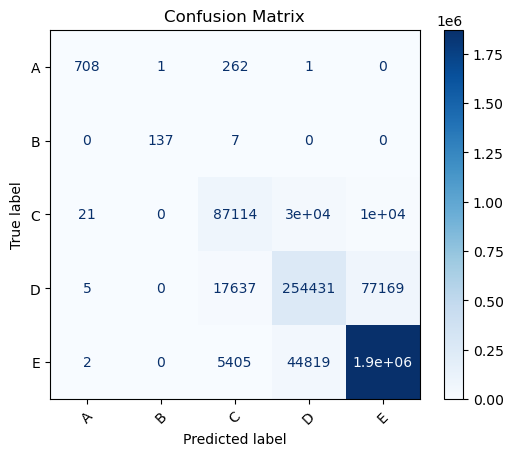


📊 클래스별 정확 예측률 (%):
- A를 A로 맞춘 비율: 72.84% (708/972)
- B를 B로 맞춘 비율: 95.14% (137/144)
- C를 C로 맞춘 비율: 68.28% (87114/127590)
- D를 D로 맞춘 비율: 72.85% (254431/349242)
- E를 E로 맞춘 비율: 97.39% (1871826/1922052)


In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ▶ 예측 수행
y_pred = final_model.predict(X_vif).flatten()

# ▶ 혼동 행렬 생성
cm = confusion_matrix(y_vif_encoded, y_pred)

# ▶ 라벨 이름 복원 (예: ['A', 'B', 'C', 'D', 'E'])
class_names = le.inverse_transform(sorted(np.unique(y_vif_encoded)))

# ▶ 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()

# ▶ 각 클래스별 정확도 계산 및 출력
print("\n📊 클래스별 정확 예측률 (%):")
for i, class_name in enumerate(class_names):
    total = cm[i].sum()
    correct = cm[i, i]
    acc = correct / total * 100 if total > 0 else 0
    print(f"- {class_name}를 {class_name}로 맞춘 비율: {acc:.2f}% ({correct}/{total})")


In [6]:
# ▶ 테스트 데이터 불러오기
test = pd.read_csv('병합/53_test.csv')

# ▶ ID 컬럼 저장 후 피처 정리
test_id = test['ID']
X_test = test[X_vif.columns]  # 컬럼 순서 맞추기
X_test = X_test.drop(columns=['ID'], errors='ignore')

# ▶ Pool 생성
test_pool = Pool(data=X_test, cat_features=cat_features)

# ▶ 예측 (class index → 문자 라벨로 복원)
preds_class = final_model.predict(test_pool)
preds_labels = le.inverse_transform(preds_class.astype(int).flatten())

# ▶ 제출 파일 생성
submission = pd.DataFrame({
    'ID': test_id,
    'Segment': preds_labels
})

# ▶ 저장
submission_path = '머신러닝_제출/submission_53.csv'
submission.to_csv(submission_path, index=False)

In [ ]:
sub = pd.read_csv(submission_path)
sub

NameError: name 'pd' is not defined

In [ ]:
# 마지막 100,000개만 추출
submission_tail = submission.tail(100000)

# 제출 파일 저장
submission_tail.to_csv(
    '/content/drive/MyDrive/멋쟁이사자처럼_파이널프로젝트/catboost/submission_tail.csv',
    index=False,
    encoding='utf-8-sig'
)

print("✅ 마지막 100,000개로 제출 파일 저장 완료!")

✅ 마지막 100,000개로 제출 파일 저장 완료!


In [7]:
sub_tail = pd.read_csv('/content/drive/MyDrive/멋쟁이사자처럼_파이널프로젝트/catboost/submission_tail.csv')
sub_tail

NameError: name 'pd' is not defined

In [8]:
import pandas as pd

In [9]:
test1 = pd.read_csv('/content/drive/MyDrive/멋쟁이사자처럼_파이널프로젝트/catboost/submission_catboost.csv')
test1

,ID,Segment
0,TEST_00000,E
1,TEST_00001,E
2,TEST_00002,D
3,TEST_00003,E
4,TEST_00004,E
...,...,...
599995,TEST_99995,E
599996,TEST_99996,E
599997,TEST_99997,E
599998,TEST_99998,C


In [7]:
# ID별 Segment 다수결
submit_df = (
    submission
    .groupby('ID')['Segment']
    .agg(lambda x: x.value_counts().idxmax())
    .reset_index()
)

# 저장
submit_df.to_csv('머신러닝_제출/submission_53_win.csv', index=False, encoding='utf-8-sig')

In [12]:
test_win = pd.read_csv('/content/drive/MyDrive/멋쟁이사자처럼_파이널프로젝트/catboost/submission_winner.csv')
test_win

,ID,Segment
0,TEST_00000,E
1,TEST_00001,E
2,TEST_00002,E
3,TEST_00003,E
4,TEST_00004,E
...,...,...
99995,TEST_99995,E
99996,TEST_99996,E
99997,TEST_99997,E
99998,TEST_99998,C


---
### 혼동행렬 그리기

In [7]:
# ───────────────────────
# 1. 라이브러리 로드
# ───────────────────────
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    f1_score
)
from catboost import CatBoostClassifier, Pool

# ───────────────────────
# 2. 경로 및 데이터 로드
# ───────────────────────
base_path = '피처_43/catboost'

X = pd.read_csv(f'{base_path}/X_vif.csv')
y = pd.read_csv(f'{base_path}/y_vif_encoded.csv')['Segment_encoded']

with open(f'{base_path}/cat_features.pkl', 'rb') as f:
    cat_features = pickle.load(f)

with open(f'{base_path}/label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

class_names = le.classes_

# ───────────────────────
# 3. Train/Valid 분할 (8:2)
# ───────────────────────
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

train_pool = Pool(X_train, y_train, cat_features=cat_features)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features)

# ───────────────────────
# 4. CatBoost 모델 학습 (로컬 GPU 사용)
# ───────────────────────
model = CatBoostClassifier(
    loss_function='MultiClass',
    eval_metric='MultiClass',
    task_type='GPU',
    devices='0',
    learning_rate=0.01,
    iterations=70000,
    early_stopping_rounds=3000,
    depth=5,
    l2_leaf_reg=50,
    border_count=64,
    random_seed=42,
    verbose=1000
)

model.fit(train_pool, eval_set=valid_pool)

# ───────────────────────
# 5. 예측 및 평가
# ───────────────────────
y_pred = model.predict(valid_pool).flatten()

0:	learn: 1.5800685	test: 1.5800826	best: 1.5800826 (0)	total: 24ms	remaining: 28m 2s
1000:	learn: 0.2859115	test: 0.2870151	best: 0.2870151 (1000)	total: 25.7s	remaining: 29m 28s


KeyboardInterrupt: 

In [ ]:
# ▸ F1 점수 출력
f1_micro = f1_score(y_valid, y_pred, average='micro')
f1_macro = f1_score(y_valid, y_pred, average='macro')

print(f"\n📌 F1 Micro: {f1_micro:.4f}")
print(f"📌 F1 Macro: {f1_macro:.4f}\n")

# ▸ Classification Report
print("[📋 Classification Report]")
print(classification_report(y_valid, y_pred, target_names=class_names, digits=4))

# ▸ 혼동 행렬 시각화
cm = confusion_matrix(y_valid, y_pred)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Validation Set)")
plt.grid(False)
plt.show()

# ▶ 각 클래스별 정확도 계산 및 출력
print("📊 클래스별 정확 예측률 (%):")
for i, class_name in enumerate(class_names):
    total = cm[i].sum()
    correct = cm[i, i]
    acc = correct / total * 100 if total > 0 else 0
    print(f"- {class_name}를 {class_name}로 맞춘 비율: {acc:.2f}% ({correct}/{total})")